### CSIRO - Image2Biomass Prediction
URL: https://www.kaggle.com/competitions/csiro-biomass/overview

### Architecture

```mermaid
graph LR
    LoadData --> Preprocess
    Preprocess --> ImageFeatures["Image Features Extraction (CNN)"]
    ImageFeatures --> TabularFeaturePrep["Tabular Feature preparation"]
    TabularFeaturePrep["Tabular Feature preparation"] --> FeatureCombination["Feature combination"]
    FeatureCombination --> LightGBM
    LightGBM --> Inference
```

In [1]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
import torch
import pandas as pd
import matplotlib.pyplot as plt

print(torch.cuda.is_available())

True


In [2]:
# data import
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')
train_df.head(6)

,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750
5,ID1012260530__Dry_Clover_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Clover_g,0.0000


In [3]:
# data check
train_df.isnull().sum()

sample_id        0
image_path       0
Sampling_Date    0
State            0
Species          0
Pre_GSHH_NDVI    0
Height_Ave_cm    0
target_name      0
target           0
dtype: int64

In [4]:
clover_g = train_df[train_df['target_name'] == 'Dry_Clover_g']
clover_g.head(6)

,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
5,ID1012260530__Dry_Clover_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Clover_g,0.0000
10,ID1025234388__Dry_Clover_g,train/ID1025234388.jpg,2015/9/1,WA,SubcloverDalkeith,0.38,1.0000,Dry_Clover_g,6.0500
15,ID1028611175__Dry_Clover_g,train/ID1028611175.jpg,2015/5/18,Tas,Ryegrass,0.66,5.0000,Dry_Clover_g,0.0000
20,ID1035947949__Dry_Clover_g,train/ID1035947949.jpg,2015/9/11,Tas,Ryegrass,0.54,3.5000,Dry_Clover_g,0.4343
25,ID1036339023__Dry_Clover_g,train/ID1036339023.jpg,2015/9/30,Vic,Phalaris_Clover,0.82,7.0000,Dry_Clover_g,23.0755


In [5]:
feature_cols = [c for c in train_df.columns if c not in ['sample_id', 'Sampling_Date']]

feature_cols

['image_path',
 'State',
 'Species',
 'Pre_GSHH_NDVI',
 'Height_Ave_cm',
 'target_name',
 'target']

TypeError: no numeric data to plot

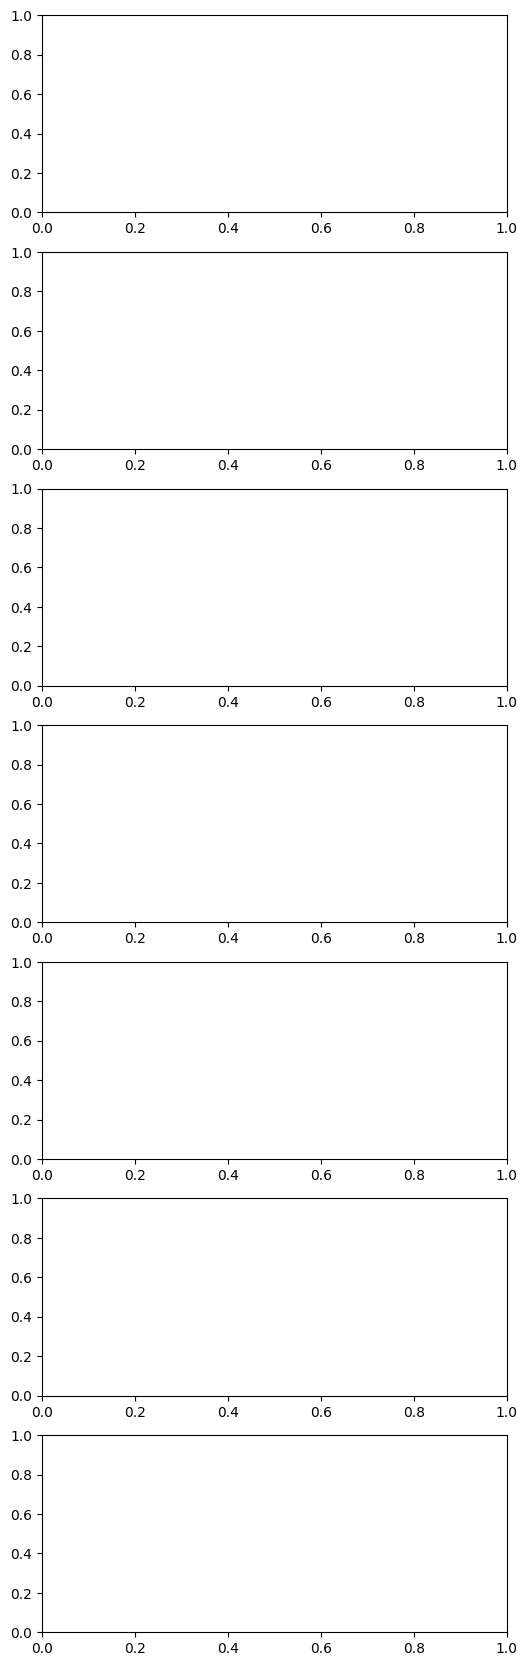

In [6]:
fig, axes = plt.subplots(len(feature_cols), 1, figsize=(6, 3 * len(feature_cols)), sharex=False)

for ax, col in zip(axes, feature_cols):
    train_df[col].plot.hist(ax=ax, bins=40, color="steelblue", alpha=0.75)
    ax.set_title(f"{col} histogram")
    ax.set_xlabel("biomass")
    ax.set_ylabel("count")

plt.tight_layout()